In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# CONFIGURACIÓN DE CLASES
CLASS_A = 2
CLASS_B = 9

CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Load CIFAR-10
transform = transforms.ToTensor()
dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Class Filters
data = []
labels = []

for img, label in dataset:
    if label == CLASS_A:
        data.append(img)
        labels.append(0)
    elif label == CLASS_B:
        data.append(img)
        labels.append(1)

print(f"Total imágenes tomadas: {len(data)} | {CLASS_NAMES[CLASS_A]} vs {CLASS_NAMES[CLASS_B]}")




100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Total imágenes tomadas: 10000 | bird vs truck


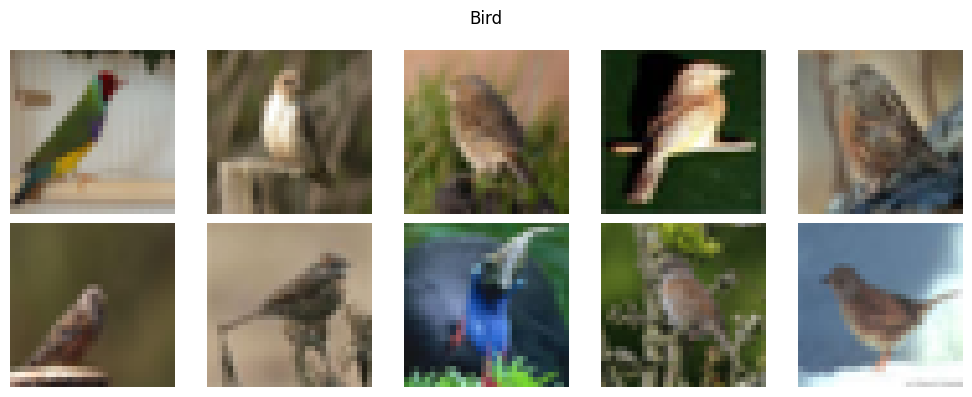

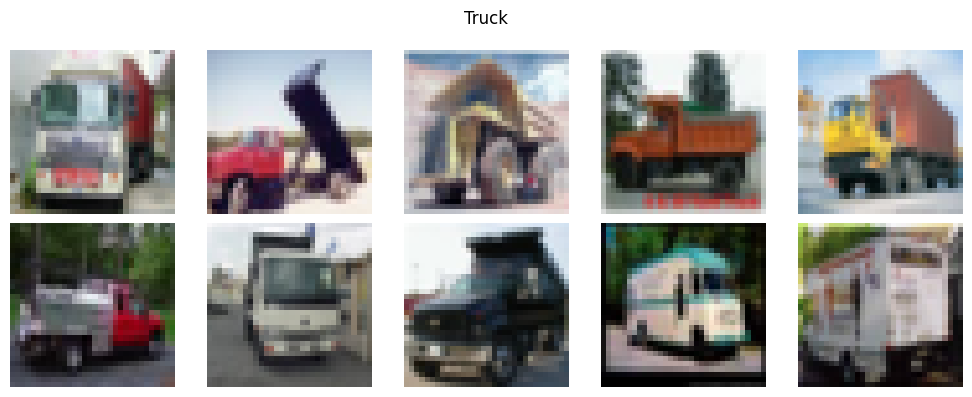

In [2]:
# Plotimages per class
def plot_images(data, labels, label_value, title):
    plt.figure(figsize=(10, 4))
    indices = [i for i, l in enumerate(labels) if l == label_value]
    n = min(10, len(indices))
    indices = np.random.choice(indices, size=n, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        img = data[idx].permute(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_images(data, labels, 0, CLASS_NAMES[CLASS_A].capitalize())
plot_images(data, labels, 1, CLASS_NAMES[CLASS_B].capitalize())

In [3]:
# Conversion to grayscale
def rgb_to_grayscale(img):
    img = img.permute(1, 2, 0).numpy()
    return np.mean(img, axis=2)

# Filter 1: Scharr (detector de bordes)
scharr_kernel = np.array([[-3, 0, 3],
                          [-10, 0, 10],
                          [-3, 0, 3]])

# Filter 2: Laplaciano (contornos generales)
laplacian_kernel = np.array([[0,  1, 0],
                             [1, -4, 1],
                             [0,  1, 0]])
# Convolution
def convolution(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    output = np.zeros((height - k_height + 1, width - k_width + 1))

    for i in range(height - k_height + 1):
        for j in range(width - k_width + 1):
            region = image[i:i + k_height, j:j + k_width]
            output[i, j] = np.sum(region * kernel)
    return output

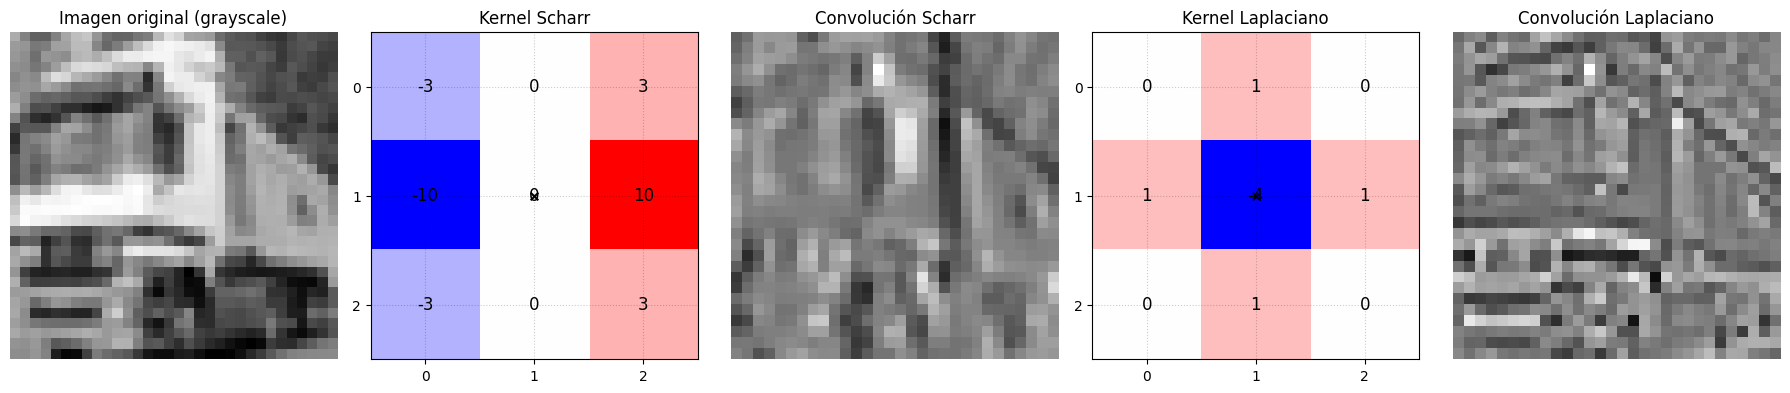

In [5]:
# Visualize
sample_img = rgb_to_grayscale(data[0])

scharr_result = convolution(sample_img, scharr_kernel)
laplacian_result = convolution(sample_img, laplacian_kernel)

plt.figure(figsize=(18, 4))

# Imagen original
plt.subplot(1, 5, 1)
plt.title("Imagen original (grayscale)")
plt.imshow(sample_img, cmap="gray")
plt.axis("off")


def draw_kernel(ax, K, title):
    K = np.array(K, dtype=float)
    vmax = np.max(np.abs(K))
    ax.imshow(K, cmap="bwr", vmin=-vmax, vmax=vmax)   # heatmap
    ax.set_title(title)
    ax.set_xticks(range(K.shape[1])); ax.set_yticks(range(K.shape[0]))
    ax.grid(color='k', alpha=0.2, linestyle=':')
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            ax.text(j, i, f"{K[i,j]:.0f}", ha='center', va='center', fontsize=12, color='black')

    ax.scatter([K.shape[1]//2], [K.shape[0]//2], color='k', s=30, marker='x')

# Kernel Scharr
plt.subplot(1, 5, 2)
draw_kernel(plt.gca(), scharr_kernel, "Kernel Scharr")

# Convolución Scharr
plt.subplot(1, 5, 3)
vmax_S = np.max(np.abs(scharr_result))
plt.title("Convolución Scharr")
plt.imshow(scharr_result, cmap="gray", vmin=-vmax_S, vmax=vmax_S)
plt.axis("off")

# Kernel Laplaciano
plt.subplot(1, 5, 4)
draw_kernel(plt.gca(), laplacian_kernel, "Kernel Laplaciano")

# Convolución Laplaciano
plt.subplot(1, 5, 5)
vmax_L = np.max(np.abs(laplacian_result))
plt.title("Convolución Laplaciano")
plt.imshow(laplacian_result, cmap="gray", vmin=-vmax_L, vmax=vmax_L)
plt.axis("off")


plt.tight_layout()
plt.show()

In [6]:
# Feature extraction
def edge_energy(img):
    gray = rgb_to_grayscale(img)
    e_s = convolution(gray, scharr_kernel)
    e_l = convolution(gray, laplacian_kernel)
    return np.mean(np.abs(e_s)) + np.mean(np.abs(e_l))

# Define threshold (without training)
bird_energy = []
truck_energy = []

n_calib = min(200, len(data))
for img, label in zip(data[:n_calib], labels[:n_calib]):
    if label == 0:
        bird_energy.append(edge_energy(img))
    else:
        truck_energy.append(edge_energy(img))

threshold = (np.mean(bird_energy) + np.mean(truck_energy)) / 2
print("Threshold:", threshold)

Threshold: 1.4463663628104855


Accuracy: 71.40%


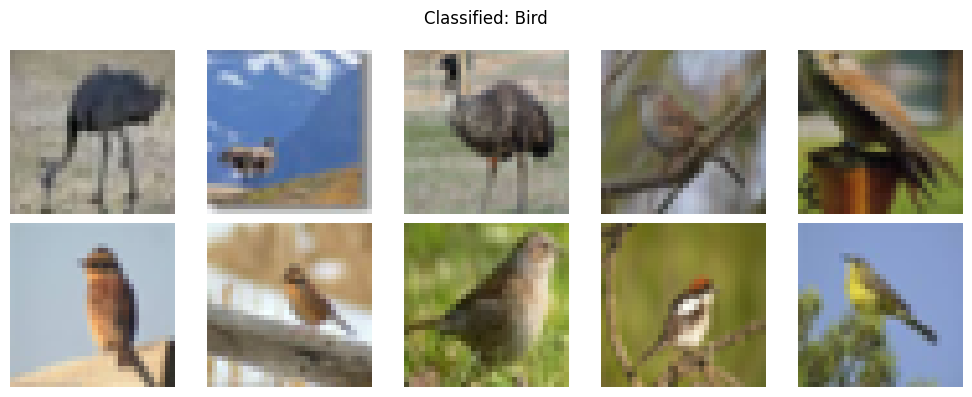

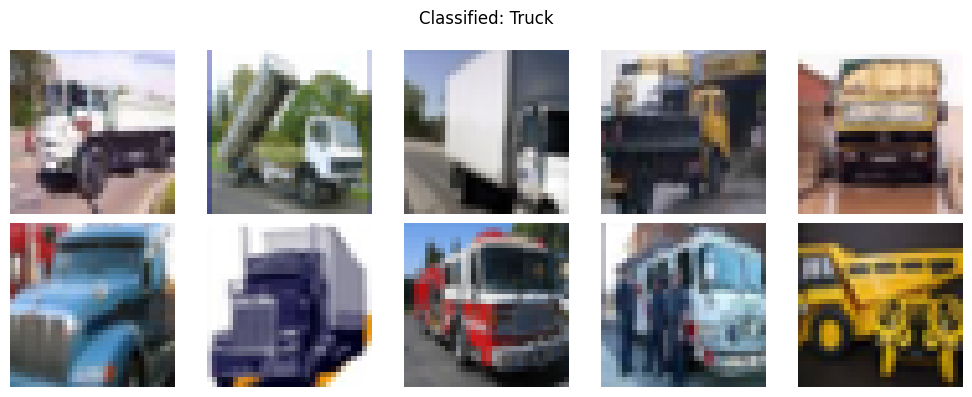

In [8]:
# Classification based on rules
def classify(img, threshold):
    energy = edge_energy(img)
    return 0 if energy < threshold else 1

# Evaluate Accuracy
start = n_calib
end = min(start + 500, len(data))
correct = 0
total = max(0, end - start)

classified_images_class_0 = []
classified_images_class_1 = []

for img, label in zip(data[start:end], labels[start:end]):
    pred = classify(img, threshold)
    if pred == label:
        correct += 1
        if label == 0:
            classified_images_class_0.append(img)
        else:
            classified_images_class_1.append(img)

accuracy = (correct / total * 100) if total > 0 else 0.0
print(f"Accuracy: {accuracy:.2f}%")

# Plot images
plot_images(classified_images_class_0, [0]*len(classified_images_class_0), 0, f"Classified: {CLASS_NAMES[CLASS_A].capitalize()}")
plot_images(classified_images_class_1, [1]*len(classified_images_class_1), 1, f"Classified: {CLASS_NAMES[CLASS_B].capitalize()}")

### Responde las siguientes preguntas:

**1. ¿Qué valores pusiste en tu Kernel 1 y por qué?**

```
Mi Kernel 1:
    [-3, 0, 3],
    [-10, 0, 10],  
    [-3, 0, 3]

Razón:
Detecta bordes verticales entonces este filtro resalta cambios bruscos en la dirección horizontal de la imagen.

```

---

**2. ¿Qué valores pusiste en tu Kernel 2 y por qué?**

```
Mi Kernel 2:
    [0, 1, 0],  
    [1, -4, 1],  
    [0, 1, 0]

Razón:
Porque resalta bordes cerrados, esquinas y cambios abruptos de intensidad.
```

---

**3. ¿Cómo funciona tu clasificador?**

```
Convierte la imagen a escala de grises.
Aplica ambos kernles.
Calcula los bordes.
Obtiene un umbral.
Y clasifica entre 0 y 1.
```

---

**4. ¿Qué patrones detecta cada kernel?**

```
Detecta bordes verticales, cambios bruscos entre columnas de pixeles.
Cambios bruscos entre columnas de píxeles
```

---

**5. Si tu clasificador no fue 100% acertado, ¿qué cambiarías?**

```
Normalizar la imagen antes, usar múltiples características, no solo energía
```

---

**6. Conexión con CNNs: ¿Cómo se relaciona esto con redes neuronales convolucionales?**

```
Se relaciona de manera que no elegimos de manera manual los kernels sino la CNN aprende sola para reconocer bordes, texturas y formas.
Además, el comparar las respuestas de dos kernels también sería cómo una CNN decide qué características son más importantes.

```

---